In [1]:
import requests
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn         import preprocessing
from matplotlib                 import pyplot as plt
from astropy.visualization.hist import hist   as fancyhist

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 



# Exploration of data

In [2]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
data.shape

(15, 8522)

In [4]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [5]:
# T90 = duration of the time interval during which 90% of the GRB photon counts are observed, starting at 5% and ending at 95%
T90  = np.array(data[6], dtype=float)
# fluence = the time integrated total energy per unit surface (erg/cm2)
fluence = np.array(data[9], dtype=float)

In [6]:
# some numbers are not real values, delete -999 from data and non-physical values
mask = np.logical_and(T90>0, fluence>0)
T90            = T90[mask]
fluence        = fluence[mask]

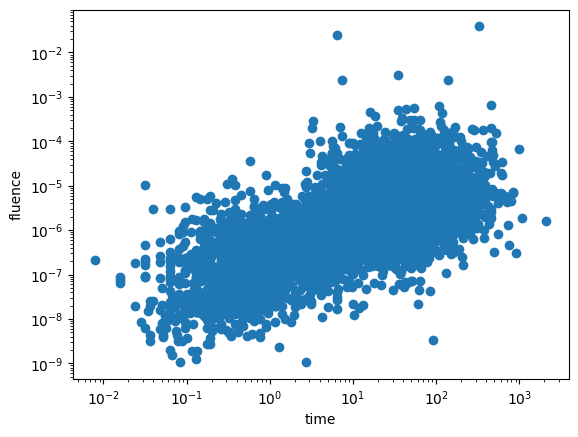

In [7]:
plt.scatter(T90, fluence)
plt.xlabel('time')
plt.ylabel('fluence')
plt.loglog()
plt.show()

I can observe two blobs, let's see if they can be two or more classes. <br>
Before that, I want to look a little bit closer the single distributions.

# Fluence + T90 1D distributions

Let's look at a histogram of the values for the fluence.

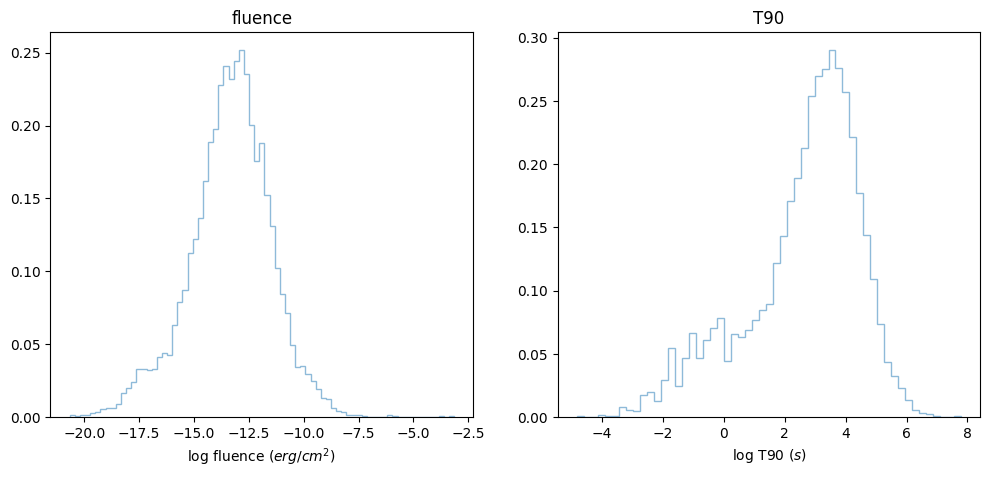

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12, 5))

# I needed to use the log, because of the distribution of the values
fancyhist(np.log(fluence), bins='freedman', alpha=0.5, ax=ax[0], histtype='step', density=True)
ax[0].set_xlabel('log fluence ($erg/cm^2$)')
ax[0].set_title('fluence')

fancyhist(np.log(T90), bins='freedman', alpha=0.5, ax=ax[1], histtype='step', density=True)
ax[1].set_xlabel('log T90 ($s$)')
ax[1].set_title('T90')
plt.show()

Could have one mode, maybe two. <br>
The distributions seem Gaussians, let's try a Gaussian Mixture model on top of them.

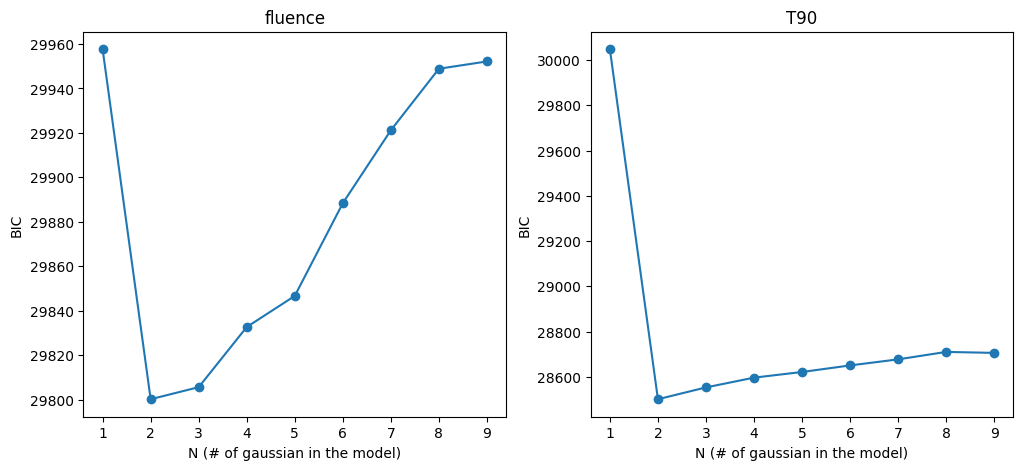

The best number of components for fluence is : 2
The best number of components for T90 is : 2


In [9]:
fig, ax = plt.subplots(1,2,figsize=(12, 5))

# Number of Gaussian to try for the fit
N = np.arange(1,10)

# with Gaussian Mixture I create different models and train it on the data using fit
models_f = np.array([GaussianMixture(n).fit(np.log(fluence[:,np.newaxis])) for n in N])
# what is the optimal number of gaussians? Let's use the BIC
# BIC incorporates a penalty term that grows with the logarithm of the sample size, it prevents overfitting
BIC_f= [model.bic(np.log(fluence[:,np.newaxis])) for model in models_f]

ax[0].plot(N, BIC_f)
ax[0].scatter(N, BIC_f)
ax[0].set_xlabel('N (# of gaussian in the model)')
ax[0].set_ylabel('BIC')
ax[0].set_title('fluence')


# same things, but with T90
models_t = np.array([GaussianMixture(n).fit(np.log(T90[:,np.newaxis])) for n in N])
BIC_t= [model.bic(np.log(T90[:,np.newaxis])) for model in models_t]

ax[1].plot(N, BIC_t)
ax[1].scatter(N, BIC_t)
ax[1].set_xlabel('N (# of gaussian in the model)')
ax[1].set_ylabel('BIC')
ax[1].set_title('T90')


plt.show()

best_N_f = N[np.argmin(BIC_f)]
best_N_t = N[np.argmin(BIC_t)]
print('The best number of components for fluence is :', best_N_f)
print('The best number of components for T90 is :', best_N_t)

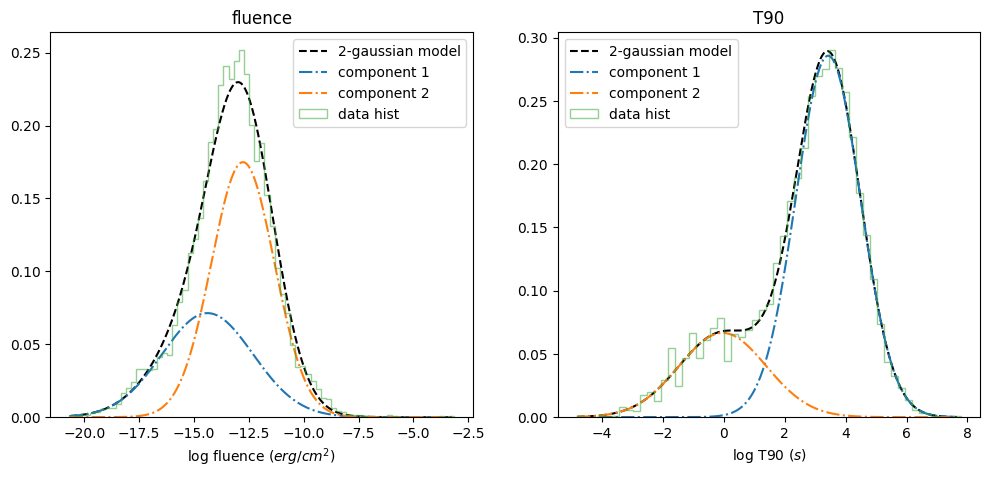

In [10]:
fig, ax = plt.subplots(1,2,figsize=(12, 5))

# Plot the model with best_N gaussians
asse_x_f = np.linspace(min(np.log(fluence[:,np.newaxis])), max(np.log(fluence[:,np.newaxis])), 1000)
# The score_sample method computes the log-likelihood of each sample
log_l_f = models_f[best_N_f-1].score_samples(asse_x_f)
# I need to do the exponentail because score_sample is a log
# pdf = exp(log_likelihood)
ax[0].plot(asse_x_f, np.exp(log_l_f), '--k', label='2-gaussian model')

# The predict_proba method evaluates the components’ density for each sample
densities_f = models_f[best_N_f-1].predict_proba(asse_x_f)
pdfs_f = densities_f*np.exp(log_l_f).reshape(-1,1)

for i in range(best_N_f):
    ax[0].plot(asse_x_f, pdfs_f[:,i], '-.', label='component %i' %(i+1))

fancyhist(np.log(fluence), bins='freedman', alpha=0.5, histtype='step', ax=ax[0], density=True, label='data hist')
ax[0].set_xlabel('log fluence ($erg/cm^2$)')
ax[0].set_title('fluence')
ax[0].legend()

# Same thing, but for T90
asse_x_t = np.linspace(min(np.log(T90[:,np.newaxis])), max(np.log(T90[:,np.newaxis])), 1000)
# The score_sample method computes the log-likelihood of each sample
log_l_t = models_t[best_N_t-1].score_samples(asse_x_t)
# I need to do the exponentail because score_sample is a log
# pdf = exp(log_likelihood)
ax[1].plot(asse_x_t, np.exp(log_l_t), '--k', label='2-gaussian model')

# The predict_proba method evaluates the components’ density for each sample
densities_t = models_t[best_N_t-1].predict_proba(asse_x_t)
pdfs_t = densities_t*np.exp(log_l_t).reshape(-1,1)

for i in range(best_N_t):
    ax[1].plot(asse_x_t, pdfs_t[:,i], '-.', label='component %i' %(i+1))
    

fancyhist(np.log(T90), bins='freedman', alpha=0.5, histtype='step', ax=ax[1], density=True, label='data hist')
ax[1].set_xlabel('log T90 ($s$)')
ax[1].set_title('T90')
ax[1].legend()
plt.show()

Based on this, I expect two clusters. <br>

## K-means

In [11]:
# I'll try with two clusters

# Fluence
km_f = KMeans(n_clusters=2)
km_f.fit(np.log(fluence[:,np.newaxis]))
centers_f = km_f.cluster_centers_ #location of the clusters
labels_f  = km_f.predict(np.log(fluence[:,np.newaxis])) #labels for each of the points

# T90
km_t = KMeans(n_clusters=2)
km_t.fit(np.log(T90[:,np.newaxis]))
centers_t = km_t.cluster_centers_
labels_t  = km_t.predict(np.log(T90[:,np.newaxis]))

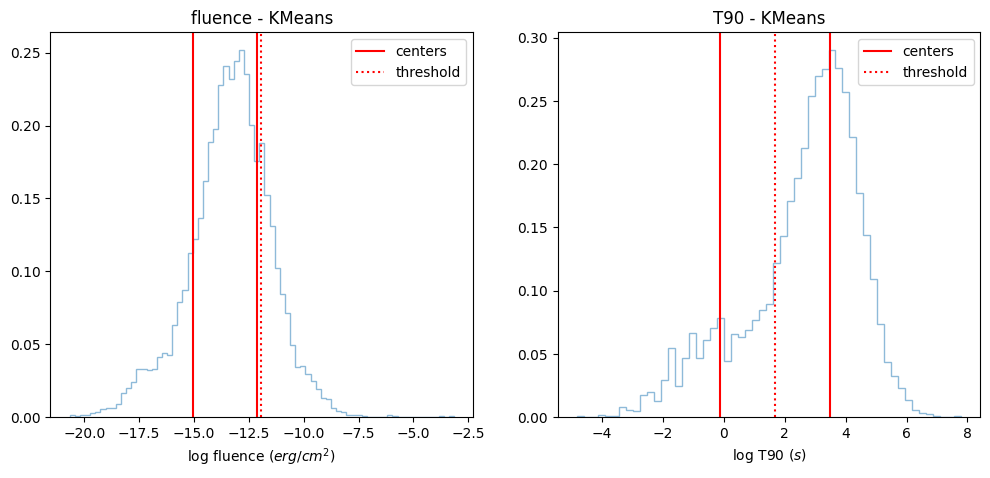

In [12]:
km_1_f = np.log(fluence[:,np.newaxis])[labels_f == 0]
km_2_f = np.log(fluence[:,np.newaxis])[labels_f == 1]

km_1_t = np.log(T90[:,np.newaxis])[labels_t == 0]
km_2_t = np.log(T90[:,np.newaxis])[labels_t == 1]

# Find the median
threshold_f = np.median([min(km_1_f), max(km_2_f)])
threshold_t = np.median([min(km_1_t), max(km_2_t)])

# Plot
fig, ax = plt.subplots(1,2,figsize=(12, 5))

fancyhist(np.log(fluence), bins='freedman', alpha=0.5, ax=ax[0], histtype='step', density=True)
ax[0].axvline(centers_f[0],color='red', label='centers')
ax[0].axvline(centers_f[1],color='red')
ax[0].axvline(threshold_f, color='red', linestyle='dotted', label = 'threshold')
ax[0].set_xlabel('log fluence ($erg/cm^2$)')
ax[0].set_title('fluence - KMeans')
ax[0].legend()

fancyhist(np.log(T90), bins='freedman', alpha=0.5, ax=ax[1], histtype='step', density=True)
ax[1].axvline(centers_t[0],color='red', label='centers')
ax[1].axvline(centers_t[1],color='red')
ax[1].axvline(threshold_t, color='red', linestyle='dotted', label = 'threshold')
ax[1].set_xlabel('log T90 ($s$)')
ax[1].set_title('T90 - KMeans')
ax[1].legend()
plt.show()

## Mean shift

For the first distribution, I am not entirely convinced that there are two clusters. <br>
I am going to use Mean Shift, that doesclusterning without pre-determining the number of clusters and see what it does!

In [13]:
# remove the mean and scale to unit variance, standardize data
scaler_f = preprocessing.StandardScaler()
scaler_t = preprocessing.StandardScaler()

# estimate_bandwidth -> gives best bandwidth
bandwidth_f = estimate_bandwidth(np.log(fluence[:,np.newaxis])) 
# cluster_all=False -> some points may also not belong to a group
ms_f = MeanShift(bandwidth=bandwidth_f, bin_seeding=True, cluster_all=False)
ms_f.fit(scaler_f.fit_transform(np.log(fluence[:,np.newaxis])))
labels_f     = np.unique(ms_f.labels_[ms_f.labels_>=0])
n_clusters_f = len(labels_f)
print("Number of estimated clusters for fluence with Mean Shift:", n_clusters_f)

bandwidth_t = estimate_bandwidth(np.log(T90[:,np.newaxis]))
ms_t = MeanShift(bandwidth=bandwidth_t*0.4, bin_seeding=True, cluster_all=False)
ms_t.fit(scaler_t.fit_transform(np.log(T90[:,np.newaxis])))
labels_t = np.unique(ms_t.labels_[ms_t.labels_>=0])
n_clusters_t = len(labels_t)
print("Number of estimated clusters for T90 with Mean Shift:", n_clusters_t)

Number of estimated clusters for fluence with Mean Shift: 2
Number of estimated clusters for T90 with Mean Shift: 2


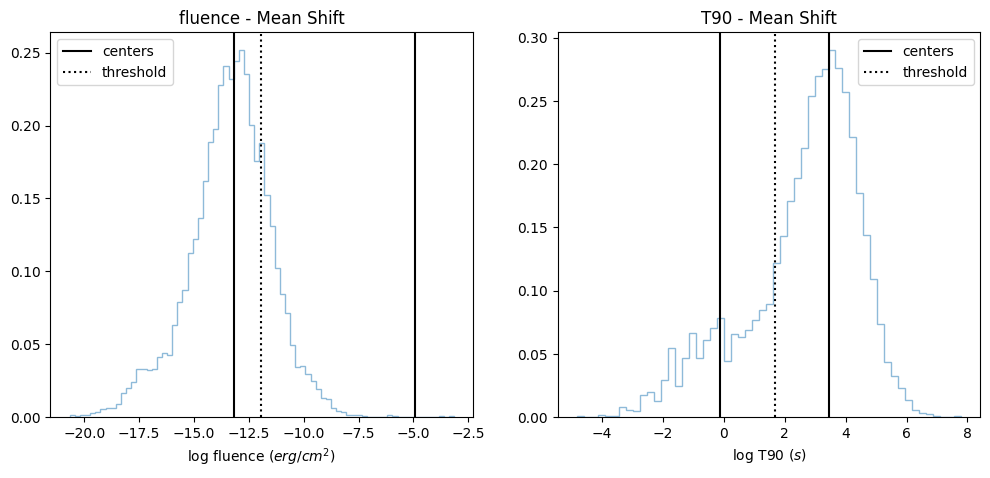

In [14]:
#finding the threshold between the two clusters 
ms_1_f = np.log(fluence[:,np.newaxis])[ms_f.labels_ == 0]
ms_2_f = np.log(fluence[:,np.newaxis])[ms_f.labels_ == 1]

ms_1_t = np.log(T90[:,np.newaxis])[ms_t.labels_ == 0]
ms_2_t = np.log(T90[:,np.newaxis])[ms_t.labels_ == 1]

# Find the median
threshold_f_ms = np.median([min(km_1_f), max(km_2_f)])
threshold_t_ms = np.median([min(km_1_t), max(km_2_t)])

# transform to go back to the original size of the dataset
cluster_centers_f = scaler_f.inverse_transform(ms_f.cluster_centers_)
cluster_centers_t = scaler_t.inverse_transform(ms_t.cluster_centers_)

# Plot
fig, ax = plt.subplots(1,2,figsize=(12, 5))

fancyhist(np.log(fluence), bins='freedman', alpha=0.5, ax=ax[0], histtype='step', density=True)
ax[0].axvline(cluster_centers_f[0],color='black', label='centers')
ax[0].axvline(cluster_centers_f[1],color='black')
ax[0].axvline(threshold_f_ms, color='black', linestyle='dotted', label = 'threshold')
ax[0].set_xlabel('log fluence ($erg/cm^2$)')
ax[0].set_title('fluence - Mean Shift')
ax[0].legend()

fancyhist(np.log(T90), bins='freedman', alpha=0.5, ax=ax[1], histtype='step', density=True)
ax[1].axvline(cluster_centers_t [0],color='black', label='centers')
ax[1].axvline(cluster_centers_t [1],color='black')
ax[1].axvline(threshold_t_ms, color='black', linestyle='dotted', label = 'threshold')
ax[1].set_xlabel('log T90 ($s$)')
ax[1].set_title('T90 - Mean Shift')
ax[1].legend()
plt.show()

Now, see the trhee methods together

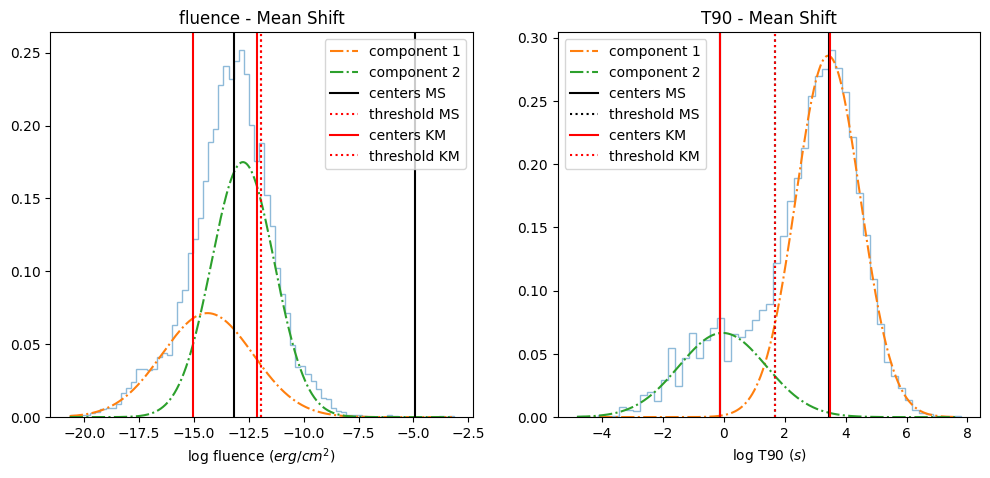

In [15]:
# Plot
fig, ax = plt.subplots(1,2,figsize=(12, 5))

fancyhist(np.log(fluence), bins='freedman', alpha=0.5, ax=ax[0], histtype='step', density=True)
for i in range(best_N_f):
    ax[0].plot(asse_x_f, pdfs_f[:,i], '-.', label='component %i' %(i+1))
ax[0].axvline(cluster_centers_f[0],color='black', label='centers MS')
ax[0].axvline(cluster_centers_f[1],color='black')
ax[0].axvline(threshold_f_ms, color='red', linestyle='dotted', label = 'threshold MS')
ax[0].axvline(centers_f[0],color='red', label='centers KM')
ax[0].axvline(centers_f[1],color='red')
ax[0].axvline(threshold_f, color='red', linestyle='dotted', label = 'threshold KM')
ax[0].set_xlabel('log fluence ($erg/cm^2$)')
ax[0].set_title('fluence - Mean Shift')
ax[0].legend()

fancyhist(np.log(T90), bins='freedman', alpha=0.5, ax=ax[1], histtype='step', density=True)
for i in range(best_N_t):
    ax[1].plot(asse_x_t, pdfs_t[:,i], '-.', label='component %i' %(i+1))
ax[1].axvline(cluster_centers_t [0],color='black', label='centers MS')
ax[1].axvline(cluster_centers_t [1],color='black')
ax[1].axvline(threshold_t_ms, color='black', linestyle='dotted', label = 'threshold MS')
ax[1].axvline(centers_t[0],color='red', label='centers KM')
ax[1].axvline(centers_t[1],color='red')
ax[1].axvline(threshold_t, color='red', linestyle='dotted', label = 'threshold KM')
ax[1].set_xlabel('log T90 ($s$)')
ax[1].set_title('T90 - Mean Shift')
ax[1].legend()
plt.show()

For fluence, the two clusters are not evident and the boundaries are not clear. <br>
I am inclined to think it has only one distribution. <br>
Let's see the results for T90:

In [16]:
# not in log space
print('Thresholds: \n KMeans: ', round(10**threshold_t,1), '\n Mean-Shift: ', round(10**threshold_t_ms,1))

print('\nCenters: \n KMeans:', round(10**centers_t[0][0],1), ' and ', 
      round(10**centers_t[1][0],1), '\n Mean-Shift: ', round(10**cluster_centers_t[0][0],1), ' and ', 
      round(10**cluster_centers_t[1][0],1))

Thresholds: 
 KMeans:  48.3 
 Mean-Shift:  48.3

Centers: 
 KMeans: 3097.3  and  0.8 
 Mean-Shift:  2735.4  and  0.7


The two algorithms have similar results!

# Fluence + T90 2D distribution

At the beginning we saw the two variables together. Let's see how can we cluster them.

2


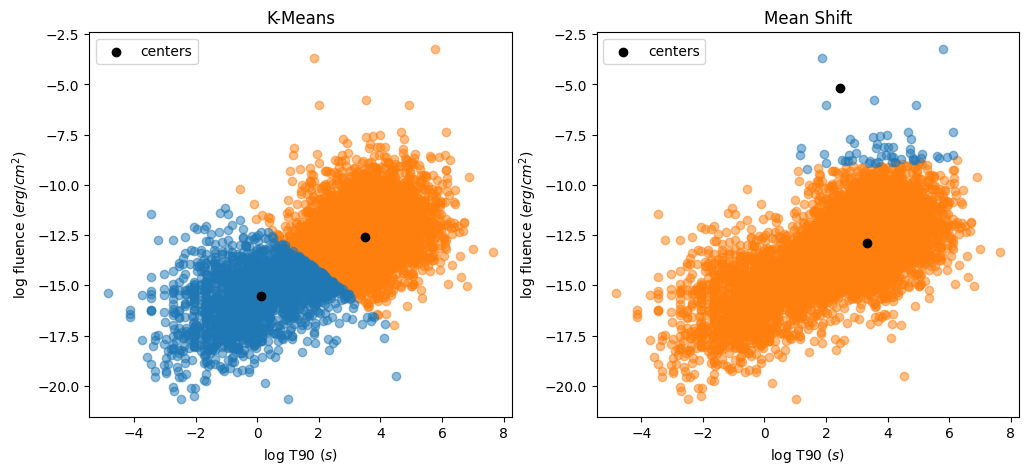

In [17]:
# K-Mean
X = np.concatenate((np.log(T90[:,np.newaxis]), np.log(fluence[:,np.newaxis])), axis=1)
# I choose n=2 just from observing the distribution
km_2D = KMeans(n_clusters=2)
km_2D.fit(X)
centers_km_2D = km_2D.cluster_centers_
labels_km_2D  = km_2D.predict(X)



bandwidth_2D = estimate_bandwidth(X)
scaler_2D = preprocessing.StandardScaler()
# with cluster_all=False I have a lot of outsiders
ms_2D = MeanShift(bandwidth=bandwidth_2D*0.6, bin_seeding=True)
ms_2D.fit(scaler_2D.fit_transform(X))
labels_2D = np.unique(ms_2D.labels_)
n_clusters_2D = len(labels_2D[labels_2D >= 0])
print(n_clusters_2D)

cluster_centers_2D = scaler_2D.inverse_transform(ms_2D.cluster_centers_)


# Plot
fig, ax = plt.subplots(1,2,figsize=(12, 5))

colors = ['C1', 'C0']
for i in range(2):
    ax[0].scatter(X[:,0][labels_km_2D==i], X[:,1][labels_km_2D==i], 
                color=colors[i],alpha=0.5)

ax[0].scatter(centers_km_2D[0,0], centers_km_2D[0,1], label='centers', c='black')
ax[0].scatter(centers_km_2D[1,0], centers_km_2D[1,1], c='black')
ax[0].legend()
ax[0].set_xlabel('log T90 ($s$)')
ax[0].set_ylabel('log fluence ($erg/cm^2$)')
ax[0].set_title('K-Means')


colors = ['C1', 'C0']
for i in range(2):
    ax[1].scatter(X[:,0][ms_2D.labels_==i], X[:,1][ms_2D.labels_==i], 
                color=colors[i],alpha=0.5)

ax[1].scatter(cluster_centers_2D[0,0], cluster_centers_2D[0,1], label='centers', c='black')
ax[1].scatter(cluster_centers_2D[1,0], cluster_centers_2D[1,1], c='black')
ax[1].legend()
ax[1].set_xlabel('log T90 ($s$)')
ax[1].set_ylabel('log fluence ($erg/cm^2$)')
ax[1].set_title('Mean Shift')
plt.show()

Comments:
- Mean shift results really dependent on the bandwidth (make sense, it's how it works). <br>
but like this a lot of centers are really outside the distributions, outlier points weights a lot!!
- I don't have this problem with k-means, but I choose the number of clusters. Mean Shift more informative for this because it takes information from the data itself.

# Positions of GRB

We can see that the main difference is in time, so a difference between high and short gamma ray brust. <br>
Are they both likely to be observed? Let's see their redhshifts:

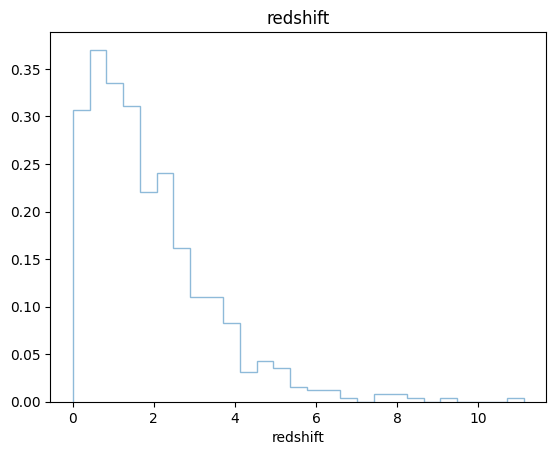

In [18]:
# Redshift ditribution
redshift = np.array(data[11], dtype=float)
_, bins, __ = fancyhist(redshift[redshift>0], bins='freedman', alpha=0.5, histtype='step', density=True)
plt.xlabel('redshift')
plt.title('redshift')
plt.show()

I don't have a lot of data, the redshifts are not estimated for all the GRBs apparently. <br>
I want to see how short and long GRBs go with redshifts. <br>
Looking only at T90, K Means and Mean Shift give similar results. I am going to use the threshold of Mean Shift.

In [19]:
T90    = np.array(data[6], dtype=float)
mask_1 = np.logical_and(T90 < threshold_t_ms, redshift>0)
mask_2 = np.logical_and(T90 > threshold_t_ms, redshift>0)

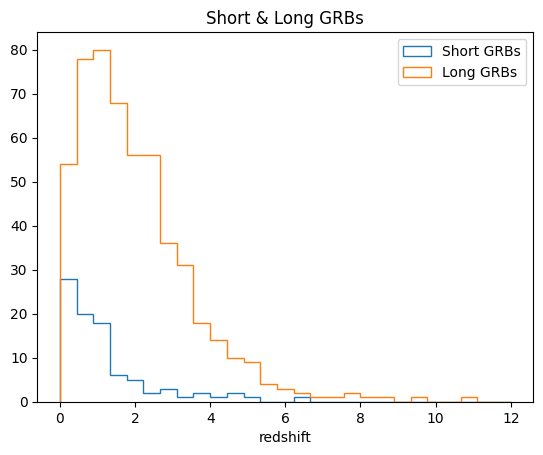

In [20]:
bins = np.linspace(0,12,len(bins))

plt.hist(redshift[mask_1], bins=bins, histtype='step', color='C0', label='Short GRBs')
plt.hist(redshift[mask_2], bins=bins, histtype='step', color='C1', label='Long GRBs')

plt.xlabel('redshift')
plt.title('Short & Long GRBs')
plt.legend()
plt.show()

I have more long GRBs than the short ones, also at high redshifts I have exclusively the long ones. <br>
They seems to peak around $z = 1$ or $2$.